In [119]:
# Import all necessary libraries and create spark session
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,upper,udf,element_at,explode,regexp_replace,size
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, DateType

from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression

import os

spark = SparkSession \
    .builder \
    .appName("FHIR Analytics with Python") \
    .getOrCreate()
#    .config("spark.sql.extensions", "com.datastax.spark.connector.CassandraSparkExtensions") \

keyspace = "myCatalog.hfs_data"

encounter_reason = "Depression"


In [120]:
# create a reference to our Cassandra catalog
spark.conf.set("spark.sql.catalog.myCatalog", "com.datastax.spark.connector.datasource.CassandraCatalog")

# Increase memory for better performance
spark.conf.set("spark.cassandra.input.split.sizeInMB", "67108864")


In [121]:
# define UDFs to pull some data out of our structs
def getMaritalStatus(ms):
    if (ms == None):
        return None
    return ms.text_
gms = udf(getMaritalStatus, StringType())
def getBirthDate(bd):
    return bd[0]
gbd = udf(getBirthDate, DateType())

# a reusable function to get a specific LOINC code and average all for by Patient ID
def getAvgForLoinc(loinc_code, agg_column, df):
    return df.filter(col("LoincCode").like(loinc_code)) \
                         .withColumnRenamed("ValueQuantity", agg_column) \
                         .select(col("Subject"), col(agg_column)) \
                         .groupBy("Subject").agg(F.round(F.avg(col(agg_column)), 3).alias(agg_column))

In [122]:
# Read in the tables we care about
rawPatient = spark.read.table(keyspace + ".patient")
rawReference = spark.read.table(keyspace + ".reference")
rawObservation = spark.read.table(keyspace + ".observation")
rawEncounter = spark.read.table(keyspace + ".encounter")

# An alternative way to read tables, left for reference
#rawReference = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "reference","keyspace": "hfs_data"}).load()
#rawObservation = spark.read.format("org.apache.spark.sql.cassandra").options(**{"table": "observation","keyspace": "hfs_data"}).load()


In [123]:
rawPatient.printSchema()

root
 |-- id: string (nullable = false)
 |-- active: boolean (nullable = true)
 |-- active_extensions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- address: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- type: string (nullable = true)
 |    |    |-- type_extensions: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- extension: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- district: string (nullable = true)
 |    |    |-- district_extensions: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- line: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- line_extensions: array (nullable = true)
 |    |    |    |-- element: array (containsNull = true)
 |    |    |    |    |-- element: string (containsNull = true)
 |    |    |-- country: 

In [124]:
# select id, maritalstatus._text, birthdate and gender from patient
# calculate patient age

patientDataFrame = rawPatient.select(col("id").alias("PatientId"), gms(col("maritalstatus")).alias("Marital Status"), col("birthdate")["0"].alias("birthdate"), upper(col("gender")).alias("Gender")).withColumn("Age", F.round(F.datediff(F.current_date(), F.to_date(col("birthdate"))) / 365, 1))

In [125]:
patientDataFrame.cache()
patientDataFrame.count()

3130

In [126]:
# select only Patient references and manipulate the column values so they are ready for joining with other tables

referenceDataFrame = rawReference.where(rawReference.reference.like("Patient%")).select(regexp_replace(rawReference.id, "#hidden", "").alias("id"), regexp_replace(rawReference.reference, "Patient/", "").alias("reference"))

In [127]:
referenceDataFrame.cache()
referenceDataFrame.count()

3174864

In [128]:
# rename some observation columns AND join with reference table to resolve Patient ID references properly

observationDataFrame = rawObservation.select(col("id").alias("ObservationId"), col("code"), col("component"), col("valuequantity"), col("subject").alias("PatientReferenceId"))
observationDataFrame = observationDataFrame.join(referenceDataFrame, referenceDataFrame.id == observationDataFrame.PatientReferenceId) \
                  .withColumn("id", col("id").cast(StringType())).withColumn("reference", col("reference").cast(StringType())) \
                  .withColumnRenamed('reference', "PatientId") \
                  .drop(col("id")) \
                  .drop(col("PatientReferenceId"))




In [129]:
# Filter and select LOINC information from observation dataframe

# observationDataFrame_loinc = observationDataFrame \
#     .select(col("PatientId").alias("Subject"), \
#             col("ObservationId"), \
#             col("code").coding[0].code.alias("LoincCode"), \
#             col("valuequantity").value.alias("ValueQuantity"))

loinc_code_list = ["8480-6", "8462-4","29463-7","8302-2","33914-3","2571-8","2085-9","18262-6","2093-3","39156-5","55284-4", "195967001", "233678006"]


# observationDataFrame_loinc = observationDataFrame_loinc \
#     .filter(col("LoincCode").isin(loinc_code_list))\
#     .na.drop()

observationDataFrame_loinc = spark.read.table(keyspace + ".resource_by_string") \
                                            .where((col("resource") == "Observation") & (col("searchParam") == "code")) \
                                            .select(col("value_1").alias("LoincCode"), col("id")) \
                                            .where(col("LoincCode").isin(loinc_code_list))

observationDataFrame_loinc = observationDataFrame_loinc.join(observationDataFrame, observationDataFrame_loinc.id == observationDataFrame.ObservationId) \
                                                       .select(col("PatientId").alias("Subject"), col("ObservationId"), col("LoincCode"), col("valuequantity").value.alias("ValueQuantity"))

In [130]:
observationDataFrame_loinc.cache()

DataFrame[Subject: string, ObservationId: string, LoincCode: string, ValueQuantity: decimal(38,18)]

In [131]:
observationDataFrame_loinc.show()

+--------------------+--------------------+---------+--------------------+
|             Subject|       ObservationId|LoincCode|       ValueQuantity|
+--------------------+--------------------+---------+--------------------+
|a2d8aacc-bd9f-4a1...|00420df7-5886-433...|   2571-8|193.5000000000000...|
|1741f0ca-1d70-49a...|006303d5-e3be-4f7...|   8302-2|133.8000000000000...|
|6fc446a2-b431-418...|015a8e5c-bb58-40c...|  39156-5|30.29000000000000...|
|55c0c4e6-3faf-42d...|019c35f9-657b-4cf...|  29463-7|83.90000000000000...|
|cdc4a78c-1736-402...|01bea728-a66b-499...|   8302-2|174.7000000000000...|
|2eb2b8a6-dfe1-43c...|01d22ac9-bc49-431...|  29463-7|81.70000000000000...|
|47bf8249-d99e-4fb...|02116418-43db-404...|   2571-8|178.4100000000000...|
|66c5ed5a-0871-400...|021de50d-d208-4d4...|   8302-2|164.2000000000000...|
|c1142904-2a8d-4c8...|024d2d86-7fbd-462...|   8302-2|166.0000000000000...|
|aa54004e-9d8e-448...|02b8b5f6-1da7-461...|   2093-3|185.1400000000000...|
|2bb1eb33-edd9-481...|030

In [132]:
# Select only Body Weight observations from pre-filtered observation data frame

body_weight_df = observationDataFrame_loinc \
    .filter(col("LoincCode").like("%29463-7%")) \
    .withColumnRenamed("ValueQuantity", "Body Weight") \
    .select(col("Subject"), col("Body Weight")) \
    .na.drop() \
    .dropDuplicates()

In [133]:
# Calculate Systolic, Diastolic and total BP, then avg per patient

blood_pressure_df = observationDataFrame.select(col("PatientId").alias("Subject"),
                          "ObservationId",
                          col("component")[0].code.coding[0].code.alias("DBPCode"), \
                          col("component")[0].valuequantity.value.alias("Diastolic Blood Pressure"), \
                          col("component")[1].code.coding[0].code.alias("SBPCode"), \
                          col("component")[1].valuequantity.value.alias("Systolic Blood Pressure")).na.drop()



blood_pressure_df = blood_pressure_df.withColumn("Blood Pressure", \
      F.round(col("Diastolic Blood Pressure")+(col("Systolic Blood Pressure") - col("Diastolic Blood Pressure"))/3))

blood_pressure_avg_df = blood_pressure_df.groupBy(col("Subject")).agg(F.round(F.avg("Diastolic Blood Pressure"), 3).alias("Diastolic BP"), \
                                           F.round(F.avg("Systolic Blood Pressure"), 3).alias("Systolic BP"), \
                                           F.round(F.avg("Blood Pressure"), 3).alias("BP") \
                                          )


In [134]:
# Select all encounters that show as Asthma diagnoses

encounterDataFrame = rawEncounter.filter(F.size(col("reasoncode")) > 0).select(col("subject"), col("reasoncode")[0].coding[0]["code"].alias(encounter_reason)) \
                                 .withColumn(encounter_reason, F.when(col(encounter_reason).isin(["36923009"]), F.lit(1)).otherwise(F.lit(0)))

encounterDataFrame = encounterDataFrame.join(referenceDataFrame, encounterDataFrame.subject == referenceDataFrame.id) \
                                               .drop("subject", "id") \
                                               .withColumnRenamed("reference", "subject")

encounterDataFrame_depression = encounterDataFrame.groupBy("subject").agg(F.max(col(encounter_reason)).alias(encounter_reason))

In [135]:
# Calculate avg body weight per patient and join with patient data frame

patient_calc_df = body_weight_df.groupBy("Subject").agg(F.round(F.avg("Body Weight"), 3).alias("Body Weight")) \
                                .join(patientDataFrame, body_weight_df.Subject == patientDataFrame.PatientId) \
                                .drop("Subject")

# Add literal demo info to patients
patient_calc_df = patient_calc_df.dropDuplicates() \
                                 .withColumn("Disease", F.array(F.lit("0"))) \
                                 .withColumn("PostalCode", F.array(F.lit("0")))

# Join BP info by patient
patient_calc_df = patient_calc_df.join(blood_pressure_avg_df, \
                                             blood_pressure_avg_df.Subject == patient_calc_df.PatientId, "left") \
                                       .drop("Subject")
     

# Join asthma info by patient
patient_calc_df = patient_calc_df.join(encounterDataFrame_depression, encounterDataFrame_depression.subject == patient_calc_df.PatientId, "left") \
                   .dropDuplicates() \
                   .drop(col("subject"))

# Calculate and join avg triglycerides by patient
triglycerides_df = getAvgForLoinc("%2571-8%", "Triglycerides", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(triglycerides_df, patient_calc_df.PatientId == triglycerides_df.Subject, "left") \
                                 .drop(col("Subject"))


# Calculate and join average EGFR by patient
egfrLoincCode = ["88294-4", "33914-3"]
agg_column = "Estimated Glomerular Filtration Rate"

egfr_df = observationDataFrame_loinc.select(col("Subject"), col("LoincCode"), col("ValueQuantity")) \
                                 .filter(col("LoincCode").isin(egfrLoincCode)) \
                                 .withColumn(agg_column, col("ValueQuantity")) \
                                 .groupBy("Subject").agg(F.round(F.avg(col(agg_column))).alias(agg_column))

patient_calc_df = patient_calc_df.join(egfr_df, patient_calc_df.PatientId == egfr_df.Subject, "left") \
                                 .drop(col("Subject"))

# Calculate and join avg LDL by patient
ldl_df = getAvgForLoinc("%18262-6%", "Low Density Lipoprotein", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(ldl_df, patient_calc_df.PatientId == ldl_df.Subject, "left") \
                   .dropDuplicates().drop(col("Subject"))


# Calculate and join average HDL by patient
hdl_df = getAvgForLoinc("%2085-9%", "High Density Lipoprotein Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(hdl_df, patient_calc_df.PatientId == hdl_df.Subject, "left") \
                   .drop(col("Subject"))

# Calculate and join average height by patient
height_df = getAvgForLoinc("%8302-2%", "Body Height", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(height_df, patient_calc_df.PatientId == height_df.Subject, "left") \
                   .drop(col("Subject"))

#Calculate and join average BMI by patient
bmi_df = getAvgForLoinc("%39156-5%", "BMI", observationDataFrame_loinc)
    
patient_calc_df = patient_calc_df.join(bmi_df, patient_calc_df.PatientId == bmi_df.Subject, "left") \
                   .drop(col("Subject"))

#Calculate and join average cholesterol by patient
cholesterol_df = getAvgForLoinc("%2093-3%", "Total Cholesterol", observationDataFrame_loinc)

patient_calc_df = patient_calc_df.join(cholesterol_df, patient_calc_df.PatientId == cholesterol_df.Subject, "left") \
                   .drop(col("Subject"))

In [136]:
# Drop some non predictors and any rows with nulls
depression_dataset = patient_calc_df.drop("PatientId", "Disease", "PostalCode", "birthdate", "Diagnosed Date").na.drop()

In [137]:
depression_dataset.cache()
# check how many patients with asthma we have after doing the cleaning of data, a good size sample is important for a good model
depression_dataset.filter(col(encounter_reason) ==1).count()

688

In [138]:
depression_dataset.count()

1155

In [139]:
depression_dataset.cache()

DataFrame[Body Weight: decimal(38,3), Marital Status: string, Gender: string, Age: double, Diastolic BP: decimal(38,3), Systolic BP: decimal(38,3), BP: decimal(38,3), Depression: int, Triglycerides: decimal(38,3), Estimated Glomerular Filtration Rate: decimal(38,0), Low Density Lipoprotein: decimal(38,3), High Density Lipoprotein Cholesterol: decimal(38,3), Body Height: decimal(38,3), BMI: decimal(38,3), Total Cholesterol: decimal(38,3)]

In [140]:
depression_dataset.show()

+-----------+--------------+------+----+------------+-----------+-------+----------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|Body Weight|Marital Status|Gender| Age|Diastolic BP|Systolic BP|     BP|Depression|Triglycerides|Estimated Glomerular Filtration Rate|Low Density Lipoprotein|High Density Lipoprotein Cholesterol|Body Height|   BMI|Total Cholesterol|
+-----------+--------------+------+----+------------+-----------+-------+----------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+
|    107.057|             M|  MALE|51.3|      80.810|    113.524| 91.714|         0|      121.210|                                   9|                 81.603|                              70.517|    186.000|31.083|          176.363|
|     81.750|             M|  MALE|60.5|      79.609|    118.043

In [141]:
trainDF = depression_dataset
# print(f"""There are {trainDF.count()} rows in the training set and {testDF.count()} in the test set""")

In [142]:
categoricalCols = [field for (field, dataType) in trainDF.dtypes if dataType == "string"]
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

stringIndexer = StringIndexer(inputCols = categoricalCols, outputCols = indexOutputCols, handleInvalid = "skip")
oheEncoder = OneHotEncoder(inputCols = indexOutputCols, outputCols = oheOutputCols)

numericCols = [field for (field, dataType) in trainDF.dtypes
                if dataType != "string" and field != encounter_reason]

assemblerInputs = oheOutputCols + numericCols

vecAssembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")



In [176]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator


kmeans = KMeans().setK(5).setSeed(1)
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, kmeans])
model = pipeline.fit(trainDF)

# Make predictions
predictions = model.transform(trainDF)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.stages[-1].clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.5477657192529455
Cluster Centers: 
[  0.74747475   0.72727273  86.70774747  68.43232323 103.88056566
 155.74583838 121.16646465 133.05845455  35.95959596  92.40586869
  65.96523232 172.94949495  28.93260606 181.31636364]
[  0.79301746   0.72817955  87.12148628  69.17007481  78.09098254
 117.21632668  91.1333616  145.98698254  87.97755611 104.42294264
  60.73156608 173.46442893  28.97075561 187.2177207 ]
[  0.81818182   0.78409091  86.11290341  66.11079545  84.2529375
 126.31555682  98.27276705 174.78840341  38.69318182 133.74565909
  49.78296591 174.22713068  28.31899432 217.55815341]
[  0.92307692   0.84615385  91.419       70.55384615  81.86569231
 123.02315385  95.57976923 348.69792308  43.07692308 145.92461538
  31.24907692 172.35384615  31.00061538 246.82030769]
[  0.79828326   0.72961373  85.66145279  64.1276824   77.92716524
 117.12388412  90.99779614 127.23425536  17.32188841  88.1627618
  68.27215665 172.77618026  28.69236695 180.

In [144]:
# predictions.show()

+-----------+--------------+------+----+------------+-----------+-------+----------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+-------------------+-----------+-----------------+-------------+--------------------+----------+
|Body Weight|Marital Status|Gender| Age|Diastolic BP|Systolic BP|     BP|Depression|Triglycerides|Estimated Glomerular Filtration Rate|Low Density Lipoprotein|High Density Lipoprotein Cholesterol|Body Height|   BMI|Total Cholesterol|Marital StatusIndex|GenderIndex|Marital StatusOHE|    GenderOHE|            features|prediction|
+-----------+--------------+------+----+------------+-----------+-------+----------+-------------+------------------------------------+-----------------------+------------------------------------+-----------+------+-----------------+-------------------+-----------+-----------------+-------------+--------------------+----------+
|    107.0

/Users/harrison/.pyenv/versions/3.7.10/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


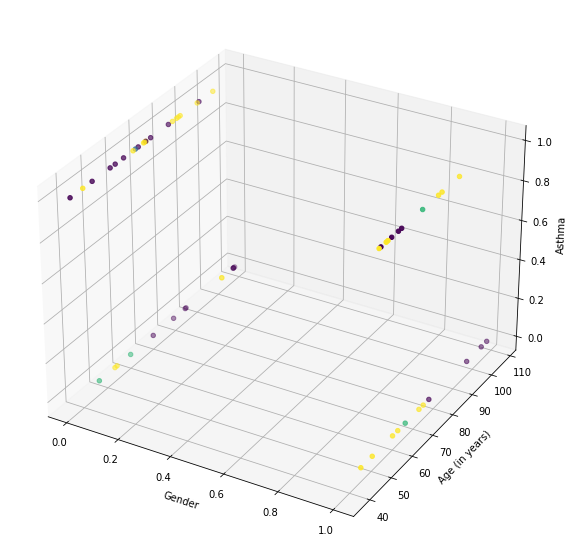

In [102]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# pandas_pred = predictions.toPandas()
# pandas_pred['Gender'] = pandas_pred['Gender'].replace({"MALE": 0, "FEMALE": 1})

# threedee = plt.figure(figsize=(12,10)).gca(projection='3d')
# threedee.scatter(pandas_pred.Gender, pandas_pred.Age, pandas_pred.Depression, c=pandas_pred.prediction)
# threedee.set_xlabel('Gender')
# threedee.set_ylabel('Age (in years)')
# threedee.set_zlabel('Depression')
# plt.show()

In [106]:
# from pyspark.ml.stat import Correlation

# r1 = Correlation.corr(predictions, "features").head()
# print("Pearson correlation matrix:\n" + str(r1[0]))

# r2 = Correlation.corr(predictions, "features", "spearman").head()
# print("Spearman correlation matrix:\n" + str(r2[0]))

17


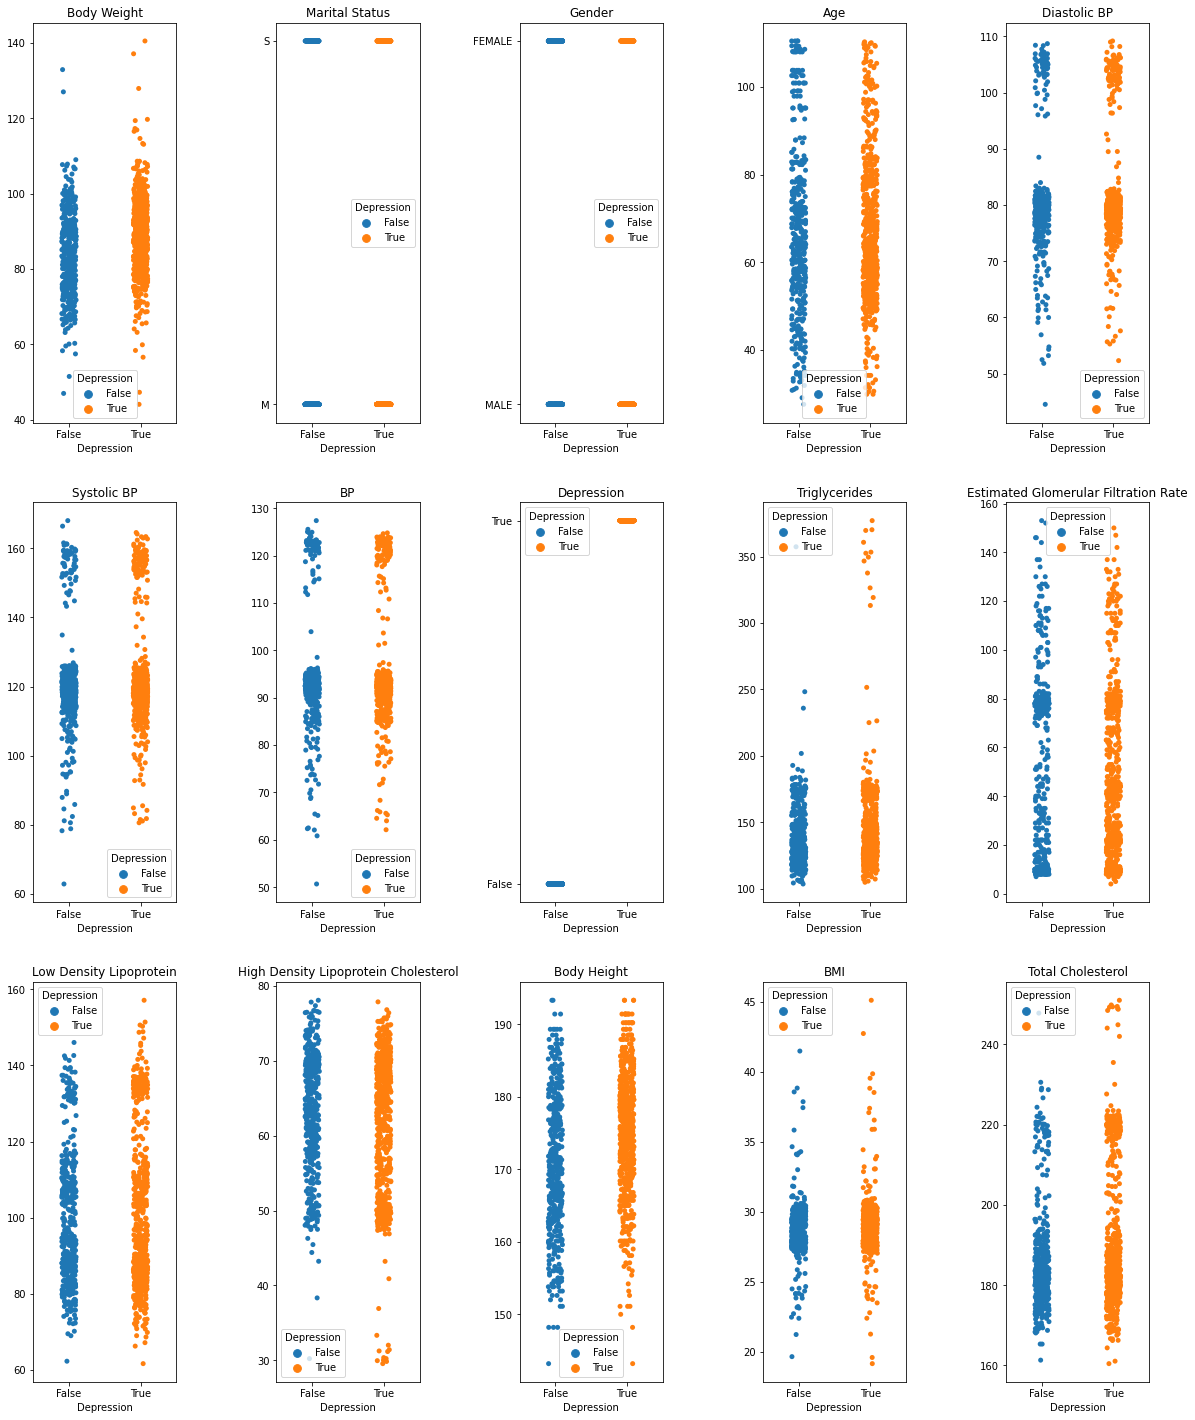

In [194]:
f, axes = plt.subplots(3, 5, figsize=(20, 25), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7)#Scooch em apart, give em some room

def getPlot(x, i):
        return sns.stripplot(x=predictions_pandas['Depression'], \
                           y=predictions_pandas[col].values, \
                           hue=predictions_pandas['Depression'], \
                           jitter=True, \
                           ax=axes[x,(i)])


#In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
print(len(list(predictions_pandas)) - 5)
for i in range(0,len(list(predictions_pandas))-7): #minus two because I don't want to plot labels or constant
    col = predictions_pandas.columns[i]
    if i < 5:
        ax = getPlot(0, i)
        ax.set_title(col)
    elif i >= 5 and i<10:
        ax = getPlot(1, i - 5)
        ax.set_title(col)
    elif i >= 10 and i<15:
        ax = getPlot(2, i - 10)
        ax.set_title(col)
    elif i >= 15:
        ax = getPlot(3, i - 15)
        ax.set_title(col)

In [196]:
# Show average of rate of depression for whole group
predictions.agg(F.avg('Depression')).show()

# Show average of rate of depression by cluster
predictions.groupBy('prediction').agg(F.avg('Depression')).show()

+------------------+
|   avg(Depression)|
+------------------+
|0.5956709956709957|
+------------------+

+----------+------------------+
|prediction|   avg(Depression)|
+----------+------------------+
|         1|0.5261845386533666|
|         3|0.9230769230769231|
|         4|0.5772532188841202|
|         2|0.7840909090909091|
|         0|0.5858585858585859|
+----------+------------------+



17


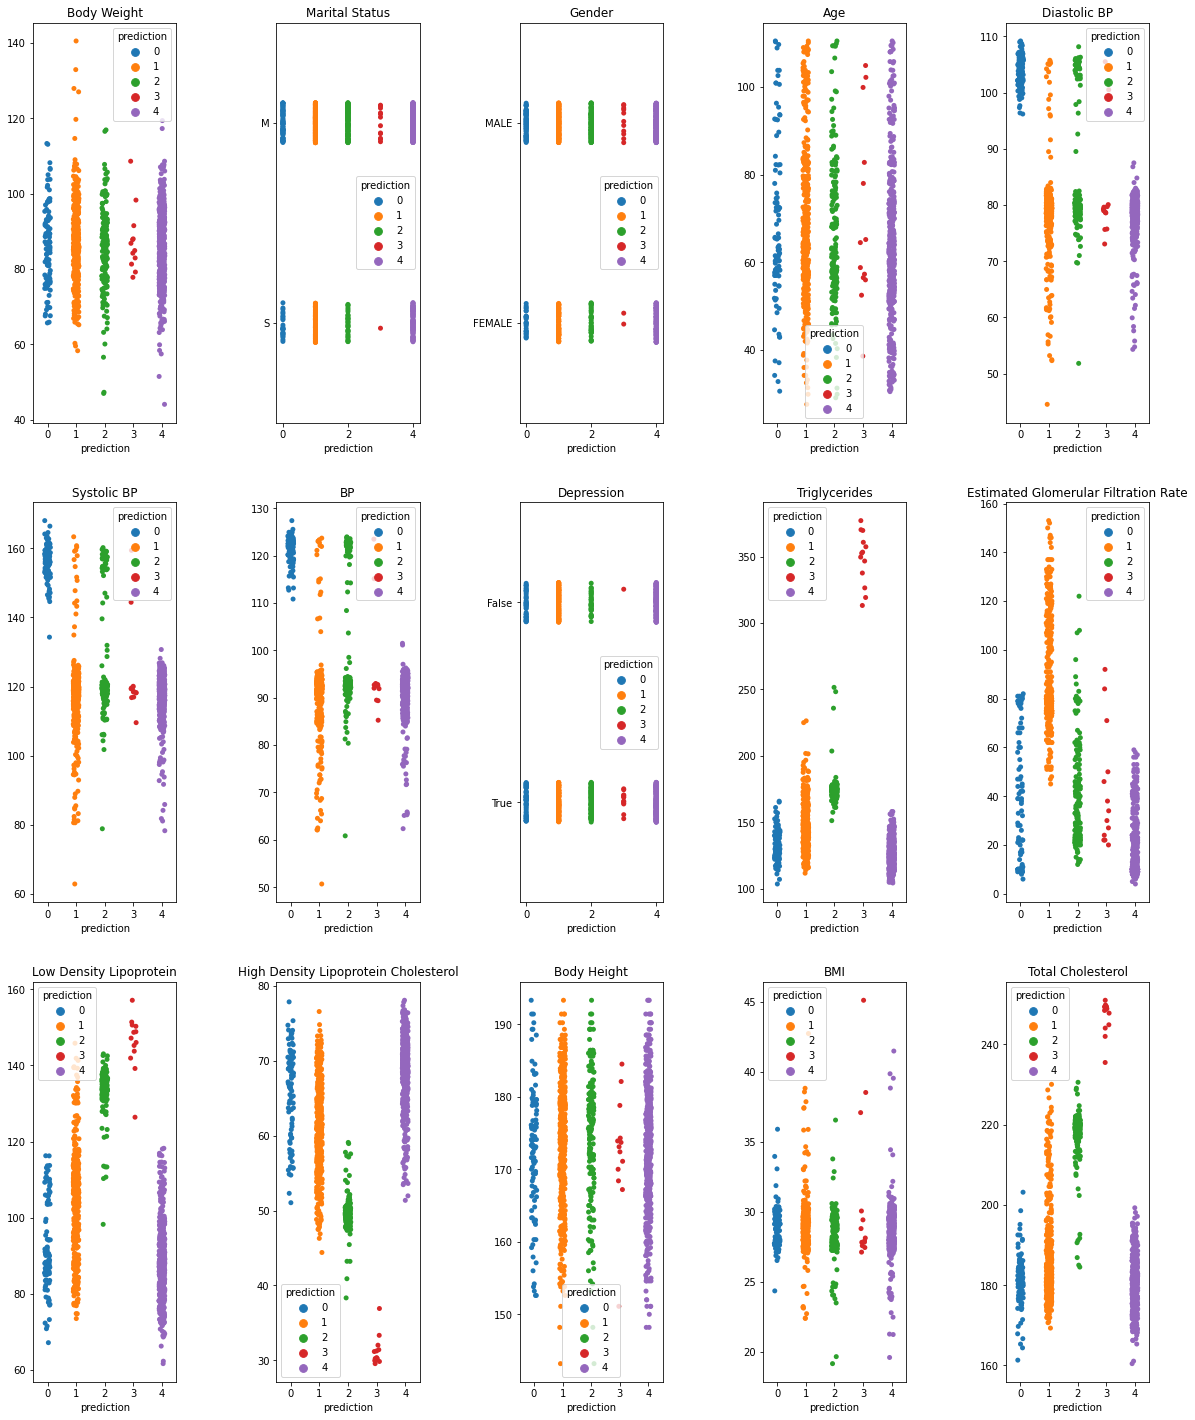

In [193]:
f, axes = plt.subplots(3, 5, figsize=(20, 25), sharex=False) #create a 4x5 grid of empty figures where we will plot our feature plots. We will have a couple empty ones.
f.subplots_adjust(hspace=0.2, wspace=0.7)#Scooch em apart, give em some room



predictions_pandas = predictions.withColumn('Constant', F.lit('Data')) \
                                .withColumn('Depression', F.when(predictions.Depression == 0, "False").otherwise("True")) \
                                .toPandas()


def getPlot(x, i):
        return sns.stripplot(x=predictions_pandas['prediction'], \
                           y=predictions_pandas[col].values, \
                           hue=predictions_pandas['prediction'], \
                           jitter=True, \
                           ax=axes[x,(i)])


#In this for loop, I step through every column that I want to plot. This is a 4x5 grid, so I split this up by rows of 5 in the else if statements
print(len(list(predictions_pandas)) - 5)
for i in range(0,len(list(predictions_pandas))-7): #minus two because I don't want to plot labels or constant
    col = predictions_pandas.columns[i]
    if i < 5:
        ax = getPlot(0, i)
        ax.set_title(col)
    elif i >= 5 and i<10:
        ax = getPlot(1, i - 5)
        ax.set_title(col)
    elif i >= 10 and i<15:
        ax = getPlot(2, i - 10)
        ax.set_title(col)
    elif i >= 15:
        ax = getPlot(3, i - 15)
        ax.set_title(col)